### Changelog
#### 1. 使用原始数据，未做normalize，使用2层same padding(k_size=3,padding=1)卷积，步长为2的池化，两个全连接层，88.7%的准确率(Linux platform)
#### 2. 和1中的所有操作相同的，但是做了normalize，准确率88.84%(linux platform)
#### 3. 利用2中的regularization，将卷积核的大小改为5，padding为2，准确率为89.15%(windows platform)
#### 4. 在3的基础上，更换optimizer算法由SGD变为Adam，准确率为89.59%(Linux platform)
#### 5. 在2的基础上，更换optimizer算法由SGD变为Adam，准确率为89.9%(Linux platform)
#### 6. 加入net.eval(),准确率上升到90.94%(Linux platform)

In [105]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [30]:
label_to_description = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress',
                        4: 'Coat', 5: 'Sandal', 6: 'Shirt',
                       7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot',
                        }

In [31]:
path_to_datasets = '/home/lor/Datasets/FashionMNIST/FashionMNIST/processed/training.pt'
# path_to_datasets = 'E:/data/FashionMNIST/FashionMNIST/processed/training.pt'
samples = torch.load(path_to_datasets)
features = samples[0]
targets = samples[1]
print(features.shape, targets.shape)
print(targets.max())
print(targets.min())

torch.Size([60000, 28, 28]) torch.Size([60000])
tensor(9)
tensor(0)


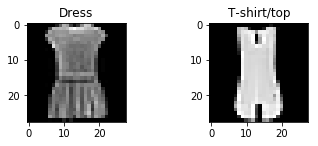

In [32]:
ax = plt.subplot(2, 2, 1)
plt.imshow(np.array(features[3]), cmap='gray')
ax.set_title(label_to_description[targets.storage()[3]])
ax = plt.subplot(2, 2, 2)
plt.imshow(np.array(features[4]), cmap='gray')
ax.set_title(label_to_description[targets.storage()[4]])
plt.show()
# plt.title(label_to_description[targets.storage()[3]])
# label_to_description[targets.storage()[3]]

In [33]:
from torch.utils.data import Dataset, DataLoader

In [34]:
class UserDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        target = self.targets[idx]
        feature = self.features[idx].unsqueeze(0).float()
        feature = (feature - torch.min(feature)) / (torch.max(feature) - torch.min(feature))
        return (target, feature)

In [47]:
train_dataset = UserDataset(features, targets)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

In [48]:
one_iter = next(iter(train_dataloader))
one_iter[0].reshape(-1)

tensor([0, 8, 2, 0, 1, 8, 8, 1, 9, 2, 1, 2, 5, 3, 7, 7, 8, 8, 2, 5, 4, 0, 7, 7,
        9, 4, 9, 6, 6, 3, 1, 9])

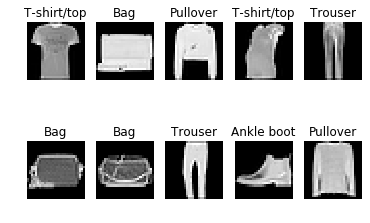

In [49]:
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(one_iter[1][i][0], cmap='gray')
    plt.axis('off')
    ax.set_title(label_to_description[one_iter[0].storage()[i]])

In [106]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 16, kernel_size=(3, 3), stride=1, padding=1),
                        nn.BatchNorm2d(16),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        
        self.conv2 = nn.Sequential(
                        nn.Conv2d(16, 24, kernel_size=(3, 3), stride=1, padding=1),
                        nn.BatchNorm2d(24),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        
        self.fc1 = nn.Linear(7 * 7 * 24, 120)
        self.fc2 = nn.Linear(120, 10)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        res = self.fc2(F.relu(out))
        
        return res

In [107]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Network()
net.to(device)
loss = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=1e-3)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

total_step = len(train_dataloader)

In [ ]:
num_epochs = 10
net.train()
for epoch in range(num_epochs):
    for i, (target, feature) in enumerate(train_dataloader):
        target, feature = target.to(device), feature.to(device)
        out = net(feature)
#         out = out.reshape(-1)
        target = target.reshape(-1)
        criterion = loss(out, target)
        
        optimizer.zero_grad()
        criterion.backward()
        optimizer.step()
        
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, criterion.item()))
        

In [111]:
### 验证
# test_path = 'E:/data/FashionMNIST/FashionMNIST/processed/test.pt'
test_path = '/home/lor/Datasets/FashionMNIST/FashionMNIST/processed/test.pt'
test_dataset = torch.load(test_path)
print(test_dataset[0].shape)
print(test_dataset[1].shape)

torch.Size([10000, 28, 28])
torch.Size([10000])


In [112]:
test_dataset = UserDataset(test_dataset[0], test_dataset[1])
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)

In [113]:
total = 10000
pred_count = 0
net.eval()
for (target, feature) in test_dataloader:
#     print(target.shape)
#     print(feature.shape)
    target = target.to(device)
    feature = feature.to(device)
    out = net(feature)
#     print(torch.argmax(out, 1))
#     print(target)
#     print(torch.argmax(out, 1) == target)
#     print((torch.argmax(out, 1) == target).sum().item())
    pred_count = pred_count + (torch.argmax(out, 1) == target).sum().item()
#     break
print("Accuracy: {0}%".format(100 * pred_count / total))

Accuracy: 91.07%


In [104]:
# Save the model
torch.save(net.state_dict(), './net.pt')

In [37]:
# Load the model
oth_net = Network()
oth_net.load_state_dict(torch.load('./net.pt'))

<All keys matched successfully>

In [38]:
oth_net.eval()

Network(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1176, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)